# Semi-Supervised Learning (SSL)


SSL studies how to learn from both labeled and unlabeled data, which can be useful when data is abundant but the resources to label them are limited.

In this exercise, you will:

* Given a simulated dataset with both labeled and unlabeled data, build a similarity graph and use the Harmonic Function Solution (HSF) to predict the labels of the unlabeled data;
* Use HSF for face recognition, given a fixed dataset;
* Implement an online version of HSF to label images as they appear in real time.

## 1. Harmonic Function Solution

Let $G = (V, E)$ be a weighted undirected graph where $V = \{x_1, \ldots, x_n \}$ is the vertex set and $E$ is the edge set. Each edge $e_{ij} \in E$ has a weight $w_{ij}$ and, if there is no edge between $x_i$ and $x_j$, then $w_{ij}=0$.

Let $|V| = n$ be the total number of nodes. Only a subset of the nodes $S \subset V$ with cardinality $|S| = l$ is labeled, and the remaining $u = n - l$ nodes are placed in the subset $T = V \setminus S$. 

Our goal is to predict the labels of the vertices in $T$ using the structure of the graph. Since we believe that nodes close in the graph should have similar labels, we would like to have each node surrounded by a majority of nodes with the same label. In order to do so, we impose that the labeling vector $f \in \mathbb{R}^n$ must be an **harmonic function** on the graph, that is:

$$
f_i = \frac{\sum_{j} w_{ij} f_j}{\sum_{j} w_{ij}},  \forall i \in T
$$

One interpretation for this constraint is that $w_{ij}$ represents the tendency of moving from node $x_i$ to node $x_j$, the stationary distribution of the transition matrix $P(j|i) = \tfrac{w_{ij}}{\sum_{k} w_{ik}}$  is a valid solution to our problem. 

### Hard HFS

It can be shown that $f$ is harmonic if and only if $(Lf)_T = 0$, where $(Lf)_T$ is the vector containing the values of $Lf$ for the nodes in the set $T$, and $L$ is the graph Laplacian. 

Hence, the harmonic function solution to the SSL problem is the solution to the following optimization problem:

$$
\min_{f \in \mathbb{R}^n}  f^T L f  
\quad \text{s.t} \quad
y_i = f(x_i) \quad \forall x_i \in S
$$
where $y_i$ are the labels available for the vertices $x_i \in S$. This gives us:

$$
f_T = L_{TT}^{-1}(W_{TS}f_S) = - L_{TT}^{-1}(L_{TS}f_S) 
$$

### Soft HFS

If the labels are noisy, we might need to replace the "hard" constraint of the optimization problem above by a "soft" constraint. Let $C$ be a diagonal matrix such that $C_{ii} = c_l$ for labeled examples and $C_{ii} = c_u$ otherwise. Also, define $y_i = 0$ for unlabeled examples, that is, for $x_i \in T$. 

The soft HFS objective function is

$$
\min_{f\in\mathbb{R}^n} (f-y)^T C (f-y) + f^T L f
$$
whose solution is 

$$
f^* = (C^{-1}L+I)^{-1}y
$$


### Implementation

Implement hard and soft HFS in the function `compute_hfs`. Complete the function `two_moons_hfs` to test your implementation using the datasets `data_2moons_hfs.mat` and `data_2moons_hfs_large.mat`.


* Tips: 
    * Don't forget to choose well the parameters to build the graph and its Laplacian.
    * You can use the functions `build_laplacian_regularized` and `build_similarity_graph`. The function `mask_labels` is used to chose how many labels are revealed.
    * Be careful: the labels are revealed randomly, and each random realization can have different results! Check how the `seed` parameter works.
    * Introduce noisy labels to compare hard and soft HFS.

In [1]:
import os
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.spatial.distance as sd
from scipy.io import loadmat
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

from helper import (
    build_laplacian,
    build_laplacian_regularized,
    build_similarity_graph,
    label_noise,
    mask_labels,
    plot_classification,
)

%load_ext autoreload
%autoreload 2

In [2]:
"""
Define parameters for HFS
"""
params = {}

# regularization parameter (gamma)
params["laplacian_regularization"] = 0.0

# the sigma value for the exponential (similarity) function, already squared
params["var"] = 1.0

# Threshold eps for epsilon graphs
params["eps"] = None

# Number of neighbours k for k-nn. If zero, use epsilon-graph
params["k"] = None

# String selecting which version of the laplacian matrix to construct.
# 'unn':  unnormalized, 'sym': symmetric normalization, 'rw':  random-walk normalization
params["laplacian_normalization"] = "unn"

# Coefficients for C matrix for soft HFS
params["c_l"] = None
params["c_u"] = None


In [3]:
def compute_hfs(L, Y, soft=False, **params):
    """
    TO BE COMPLETED

    Function to perform HFS (hard or soft!).

    Parameters
    ----------
    L : array
        Graph Laplacian, (n x n) matrix (regularized or not)
    Y : array
        (n, ) array with nodes labels [0, 1, ... , num_classes] (0 is unlabeled)
    soft : bool
        If True, compute soft HFS. Otherwise, compute hard HFS.

    Returns
    --------
        Labels, class assignments for each of the n nodes
    """

    num_samples = L.shape[0]
    Cl = np.unique(Y)
    num_classes = len(Cl) - 1

    """
    Build the vectors:
    y = (n x num_classes) target vector 
    l_idx = shape (l,) vector with indices of labeled nodes
    u_idx = shape (u,) vector with indices of unlabeled nodes
    """
    y = np.zeros((num_samples, num_classes))
    l_idx = np.arange(len(Y))[Y != 0]
    u_idx = np.arange(len(Y))[Y == 0]
    y[l_idx, Y[l_idx].astype(int) - 1] = 1

    if not soft:
        """
        Compute hard HFS.

        f_l = solution for labeled data.
        f_u = solution for unlabeled data
        f   = solution for all data
        """
        f_l = y[l_idx]
        L_ul = L[u_idx, :][:, l_idx]
        L_uu = L[u_idx, :][:, u_idx]
        f_u = np.linalg.solve(L_uu, -L_ul @ f_l)

        f = np.zeros(y.shape)
        f[l_idx] = f_l
        f[u_idx] = f_u

    else:
        """
        Compute soft HFS.
        f = harmonic function solution
        C = (n x n) diagonal matrix with c_l for labeled samples and c_u otherwise
        """
        C = np.zeros(num_samples)
        C[l_idx] = params["c_l"]
        C[u_idx] = params["c_u"]
        C = np.diag(C)
        f = np.linalg.solve(np.linalg.pinv(C) @ L + np.eye(num_samples), y)

    """
    return the labels assignment from the hfs solution, and the solution f
    labels: (n x 1) class assignments [1,2,...,num_classes]    
    f : harmonic function solution
    """
    labels = np.argmax(f, axis=1) + 1
    return labels, f


In [4]:
def two_moons_hfs(
    l=4,
    l_noisy=1,
    soft=False,
    dataset="data_2moons_hfs.mat",
    plot=True,
    seed=None,
    **params,
):
    """
    TO BE COMPLETED.

    HFS for two_moons data.

    Parameters
    ----------
    l : int
        Number of labeled (unmasked) nodes provided to the HFS algorithm.
    l_noisy : int
        Number of *noisy* labels to introduce.
    soft : bool
        If true, use soft HFS, otherwise use hard HFS
    dataset : {'data_2moons_hfs.mat' or 'data_2moons_hfs_large.mat'}
        Which dataset to use.
    plot : bool
        If True, show plots
    seed : int
        If not None, set global numpy seed before choosing labels to reveal.
    """
    if seed is not None:
        np.random.seed(seed)

    # Load the data. At home, try to use the larger dataset.
    in_data = loadmat(os.path.join("data", dataset))
    X = in_data["X"]
    Y = np.array(in_data["Y"].squeeze(), dtype=np.uint32)

    # infer number of labels from samples
    num_samples = np.size(Y, 0)
    unique_classes = np.unique(Y)
    num_classes = len(unique_classes)

    # mask labels
    Y_masked = mask_labels(Y, l, per_class=True)
    assert len(np.unique(Y_masked)) > 2, "only one class in training data!"
    # introduce noise
    noise_indices = np.where(Y_masked == 0)[0]
    np.random.shuffle(noise_indices)
    noise_indices = noise_indices[:l_noisy]
    Y_masked[noise_indices] = np.random.choice(unique_classes, l_noisy)

    """
    compute hfs solution using either soft_hfs or hard_hfs
    """
    # Build graph Laplacian using the parameters:
    # params['laplacian_regularization'], params['var'], params['eps'],
    # params['k'] and params['laplacian_normalization'].

    L = build_laplacian_regularized(
        X,
        params["laplacian_regularization"],
        var=params["var"],
        eps=params["eps"],
        k=params["k"],
        laplacian_normalization=params["laplacian_normalization"],
    )
    labels, f = compute_hfs(L, Y_masked, soft, **params)

    # Visualize results
    if plot:
        plot_classification(
            X,
            Y,
            Y_masked,
            noise_indices,
            labels,
            params["var"],
            params["eps"],
            params["k"],
        )
    accuracy = np.mean(labels == np.squeeze(Y))
    print(f"Soft={soft}, Accuracy={accuracy}")
    return X, Y, labels, accuracy


### Question 1.1 - Report the accuracy you obtained for `data_2moons_hfs.mat` dataset using hard HFS, when l=10 and l_noisy=0. 

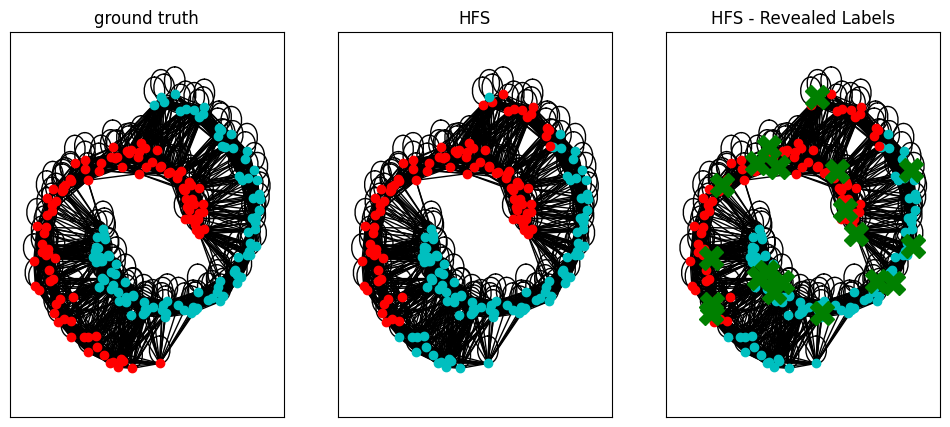

Soft=False, Accuracy=0.865


In [5]:
params["k"] = 27
params["laplacian_normalization"] = "rw"

seed = 42
X, Y, hard_labels, hard_accuracy = two_moons_hfs(
    l=10,
    l_noisy=0,
    soft=False,
    dataset="data_2moons_hfs.mat",
    plot=True,
    seed=seed,
    **params
)


> Note: I decided to choose not a too small $k$ when building the graph, otherwise, the classification task becomes too easy.

### Question 1.2  - Using `data_2moons_hfs_large.mat`, run `two_moons_hfs` several times with l=4. What can go wrong?

* Tips:
    * When running `two_moons_hfs` several times, don't forget to set `seed=None`

In [6]:
# per_class set to True
np.random.seed(42)
for ii in range(20):
    X, Y, hard_labels, hard_accuracy = two_moons_hfs(
        l=4,
        l_noisy=0,
        soft=False,
        dataset="data_2moons_hfs_large.mat",
        plot=False,
        seed=None,
        **params
    )

# mask_labels?  # check parameters


Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0


When there are too few labels in the dataset, we can end up in a situation where we only have one kind of labels. Our model will always output that specific label.
Hopefully, the used functions raises an error when we only have one kind of labels.

One way to fix the class imbalance is to add `per_class=True`, when doing the mask.

### Question 1.3 - Using `data_2moons_hfs.mat`, l=10 and l_noisy=5, compare hard HFS to soft HFS. Report the accuracy and comment the results.

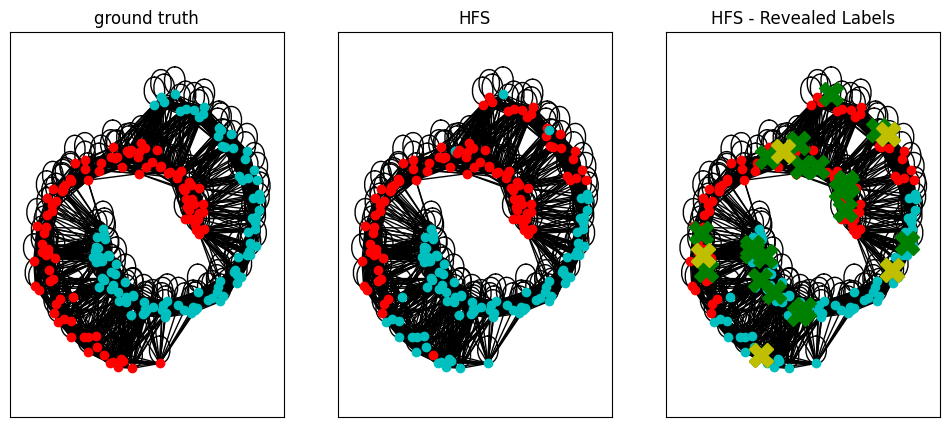

Soft=False, Accuracy=0.8


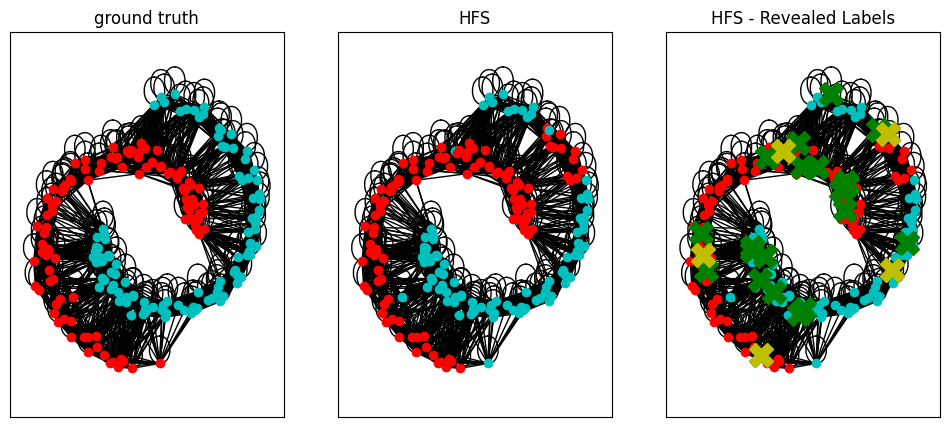

Soft=True, Accuracy=0.925


In [7]:
# Comparing
seed = 5  # To run several times with random outcomes, set seed=None. Otherwise, set a seed for reproducibility.
plot = True
dataset = "data_2moons_hfs.mat"  # Try also 'data_2moons_hfs_large.mat'

params["laplacian_regularization"] = 0
X, Y, hard_labels, hard_accuracy = two_moons_hfs(
    l=10, l_noisy=5, soft=False, dataset=dataset, plot=plot, seed=seed, **params
)

params["laplacian_regularization"] = 1
params["c_l"] = 0.95
params["c_u"] = 0.1
X, Y, soft_labels, soft_accuracy = two_moons_hfs(
    l=10, l_noisy=5, soft=True, dataset=dataset, plot=plot, seed=seed, **params
)


Our results are better with the soft HFS.


## 2. Face recognition with HFS

Now, we apply HFS to the task of face recognition, that is, our goal is to classify faces as belonging to different people. Since faces all share common features, it can be a good idea to leverage a large quantity of unlabeled data to improve classification accuracy. In this part of the exercise, you will:

* Extract faces from the images using OpenCV for face detection, and use the same library to apply preprocessing steps;
* Run HFS for classification.

### Implementation

Choose the hyperparameters and run HFS for face recognition, using both the small and large dataset. You can try to change the preprocessing steps (e.g. equalizeHist, GaussianBlur) applied to the images.

**Important**: make sure your HFS code is able to handle more than two classes!

### Question 2.1 - How did you manage to label more than two classes?

In order to manage more than 2 classes, we consider $y \in \{1, \cdots, N\}$. Then HFS must simply return a vector of length $N$, where coordinate $i$ represents the probability of belonging to class $i$. 

The final prediction is obtained by taking the $\argmax + 1$ of the probability vector.

### Question 2.2 - Report the best accuracy you obtained for both (small and augmented) datasets.

* Tips:
    * The small dataset (10 images per person) is loaded with `load_image_data`.
    * Use `load_image_data_augmented` for the augmented dataset (50 images per person). 

We make a grid search on all the parameters to find the best combination for the maximum accuracy.

**On both datasets:**
* `laplacian_regularization`: 0.01
* `var`: 100
* `k`: 10
* `laplacian_normalization`: "rw"
* `c_l`: 0.6
* `c_u`: 0.01

We find the following accuracies:
|  | Small Dataset | Augmented Dataset |
|---|---|---|
| Accuracy | 83.0% | 67.0% |


I also slightly change the Gaussian blur in the pre-processing step so that it has a bigger receiptive field.


### Question 2.3 - If the accuracy changes when using the augmented dataset, explain why. Does using additional data always increase the performance?

Thanks to the confusion matrix, we notice that some faces are easier to classify. Faces 1, 4 and 8 are easy to classify in the small dataset, whereas face 5 is easy to classify in the augmented dataset. We also see that face 2 is overpredicted in the augmented dataset.

In the end, the performances using the augmented dataset didn't benefit the augmentation at all: the performances are much worse. There are several reasons explaining the lack of improvement:
1. the small dataset has 4 labels per class, which gives 60% of missing data. The augmented dataset has still 4 labels per class, but it results in 92% of missing data. In this case, the ratio of missing data is too big, and the information can't be propagated in the graph. A big amount of missing data could still work in the 2-moons dataset, as the classes were highly separable. It is not the case when dealing with faces.
2. the faces in the augmented dataset are not always real life faces. We can compare our approach to FaceID on Apple, which reaches more than 99% of accuracy. In the augmented dataset, some faces are too weird, and would not happen in real life when holding a smartphone to unlock it.

In [8]:
import matplotlib.pyplot as plt
from imageio import imread
import numpy as np
import cv2
import os

from load_images import load_image_data, plot_image_data
from load_images import load_image_data_augmented, plot_image_data_augmented


In [9]:
"""
Define parameters for face recognition with HFS
"""
params_face_rec = {}
params_face_rec["laplacian_regularization"] = 1.0
params_face_rec["var"] = 10.0
params_face_rec["eps"] = None
params_face_rec["k"] = 20
params_face_rec["laplacian_normalization"] = "rw"
params_face_rec["c_l"] = 0.7
params_face_rec["c_u"] = 0.0


In [10]:
# Function to preprocess the images
# You may try to change it and check the impact on the classification accuracy
def preprocess_image(image):
    """
    Parameters
    ----------
    image : array
        (width, height) array representing a grayscale image

    Returns
    -------
        (96, 96) preprocessed image
    """
    output_frame_size = 96  # do not change the output frame size!
    image = cv2.bilateralFilter(image, 9, 75, 75)
    image = cv2.equalizeHist(image)
    image = cv2.GaussianBlur(image, (15, 15), 3)
    im = cv2.resize(image, (output_frame_size, output_frame_size)).astype(np.float)
    im -= im.mean()
    im /= im.max()
    image = im
    return image


In [11]:
# 10 images per person
np.random.seed(456)  # set seed, since labels are masked randomly
images, labels, masked_labels = load_image_data(preprocess_image)

# 50 images per person
images_a, labels_a, masked_labels_a = load_image_data_augmented(preprocess_image)


/tmp/ipykernel_1213/431548746.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im = cv2.resize(image, (output_frame_size, output_frame_size)).astype(np.float)


Samples in the small dataset:


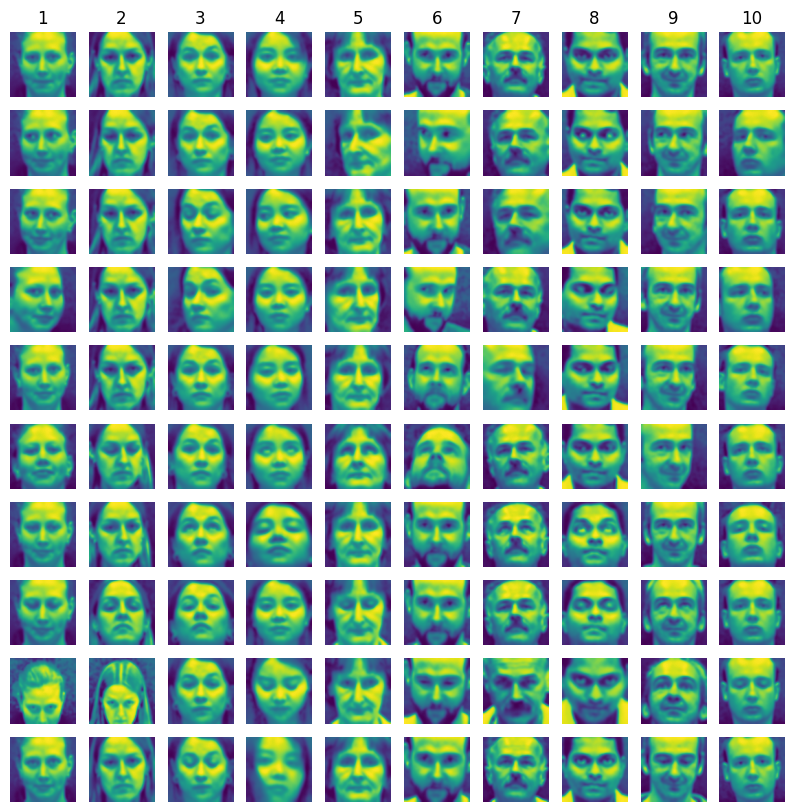

Percent of missing data in small dataset: 60.00%


In [12]:
print("Samples in the small dataset:")
plot_image_data(images)
print(
    "Percent of missing data in small dataset: {:.2f}%".format(
        100 * np.mean(masked_labels == 0)
    )
)


Samples in the augmented dataset:
(weird images have a border)


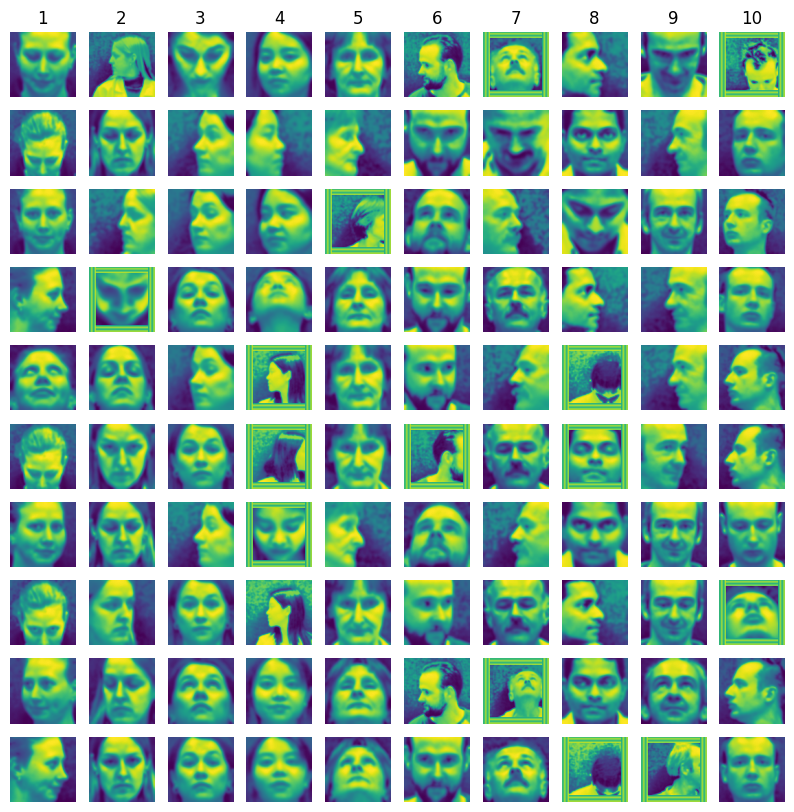

Percent of missing data in augmented dataset: 92.00%


In [13]:
print("Samples in the augmented dataset:")
print("(weird images have a border)")
plot_images = images_a.copy()
for weird_image_index in [6, 9, 24, 31, 43, 47, 53, 55, 57, 63, 79, 86, 97, 98]:
    img = plot_images[weird_image_index]
    n = int(np.sqrt(len(img)))
    img = img.reshape(n, n)
    img[:10] = 1
    img[:10:2] = 0
    img[-10:] = 1
    img[-10::2] = 0
    img[:, :10] = 1
    img[:, :10:2] = 0
    img[:, -10:] = 1
    img[:, -10::2] = 0
    plot_images[weird_image_index] = img.flatten()
plot_image_data(plot_images[:100])
print(
    "Percent of missing data in augmented dataset: {:.2f}%".format(
        100 * np.mean(masked_labels_a == 0)
    )
)


In [14]:
# graph Laplacian
params_face_rec = {}
params_face_rec["laplacian_regularization"] = 0.1
params_face_rec["var"] = 100
params_face_rec["eps"] = 0
params_face_rec["k"] = 10
params_face_rec["laplacian_normalization"] = "rw"
params_face_rec["c_l"] = 0.9
params_face_rec["c_u"] = 0.01

# Small dataset
L = build_laplacian_regularized(
    images,
    params_face_rec["laplacian_regularization"],
    params_face_rec["var"],
    params_face_rec["eps"],
    params_face_rec["k"],
    params_face_rec["laplacian_normalization"],
)
# Augmented dataset
L_a = build_laplacian_regularized(
    images_a,
    params_face_rec["laplacian_regularization"],
    params_face_rec["var"],
    params_face_rec["eps"],
    params_face_rec["k"],
    params_face_rec["laplacian_normalization"],
)

# Run HFS
predicted_labels, f = compute_hfs(L, masked_labels, soft=True, **params_face_rec)
accuracy = np.equal(predicted_labels, labels).mean()
predicted_labels_a, f_a = compute_hfs(
    L_a, masked_labels_a, soft=True, **params_face_rec
)
accuracy_a = np.equal(predicted_labels_a, labels_a).mean()

print("Accuracy small dataset: {:.2f}%".format(100 * accuracy))
print("Accuracy augme dataset: {:.2f}%".format(100 * accuracy_a))


Accuracy small dataset: 84.00%
Accuracy augme dataset: 65.40%


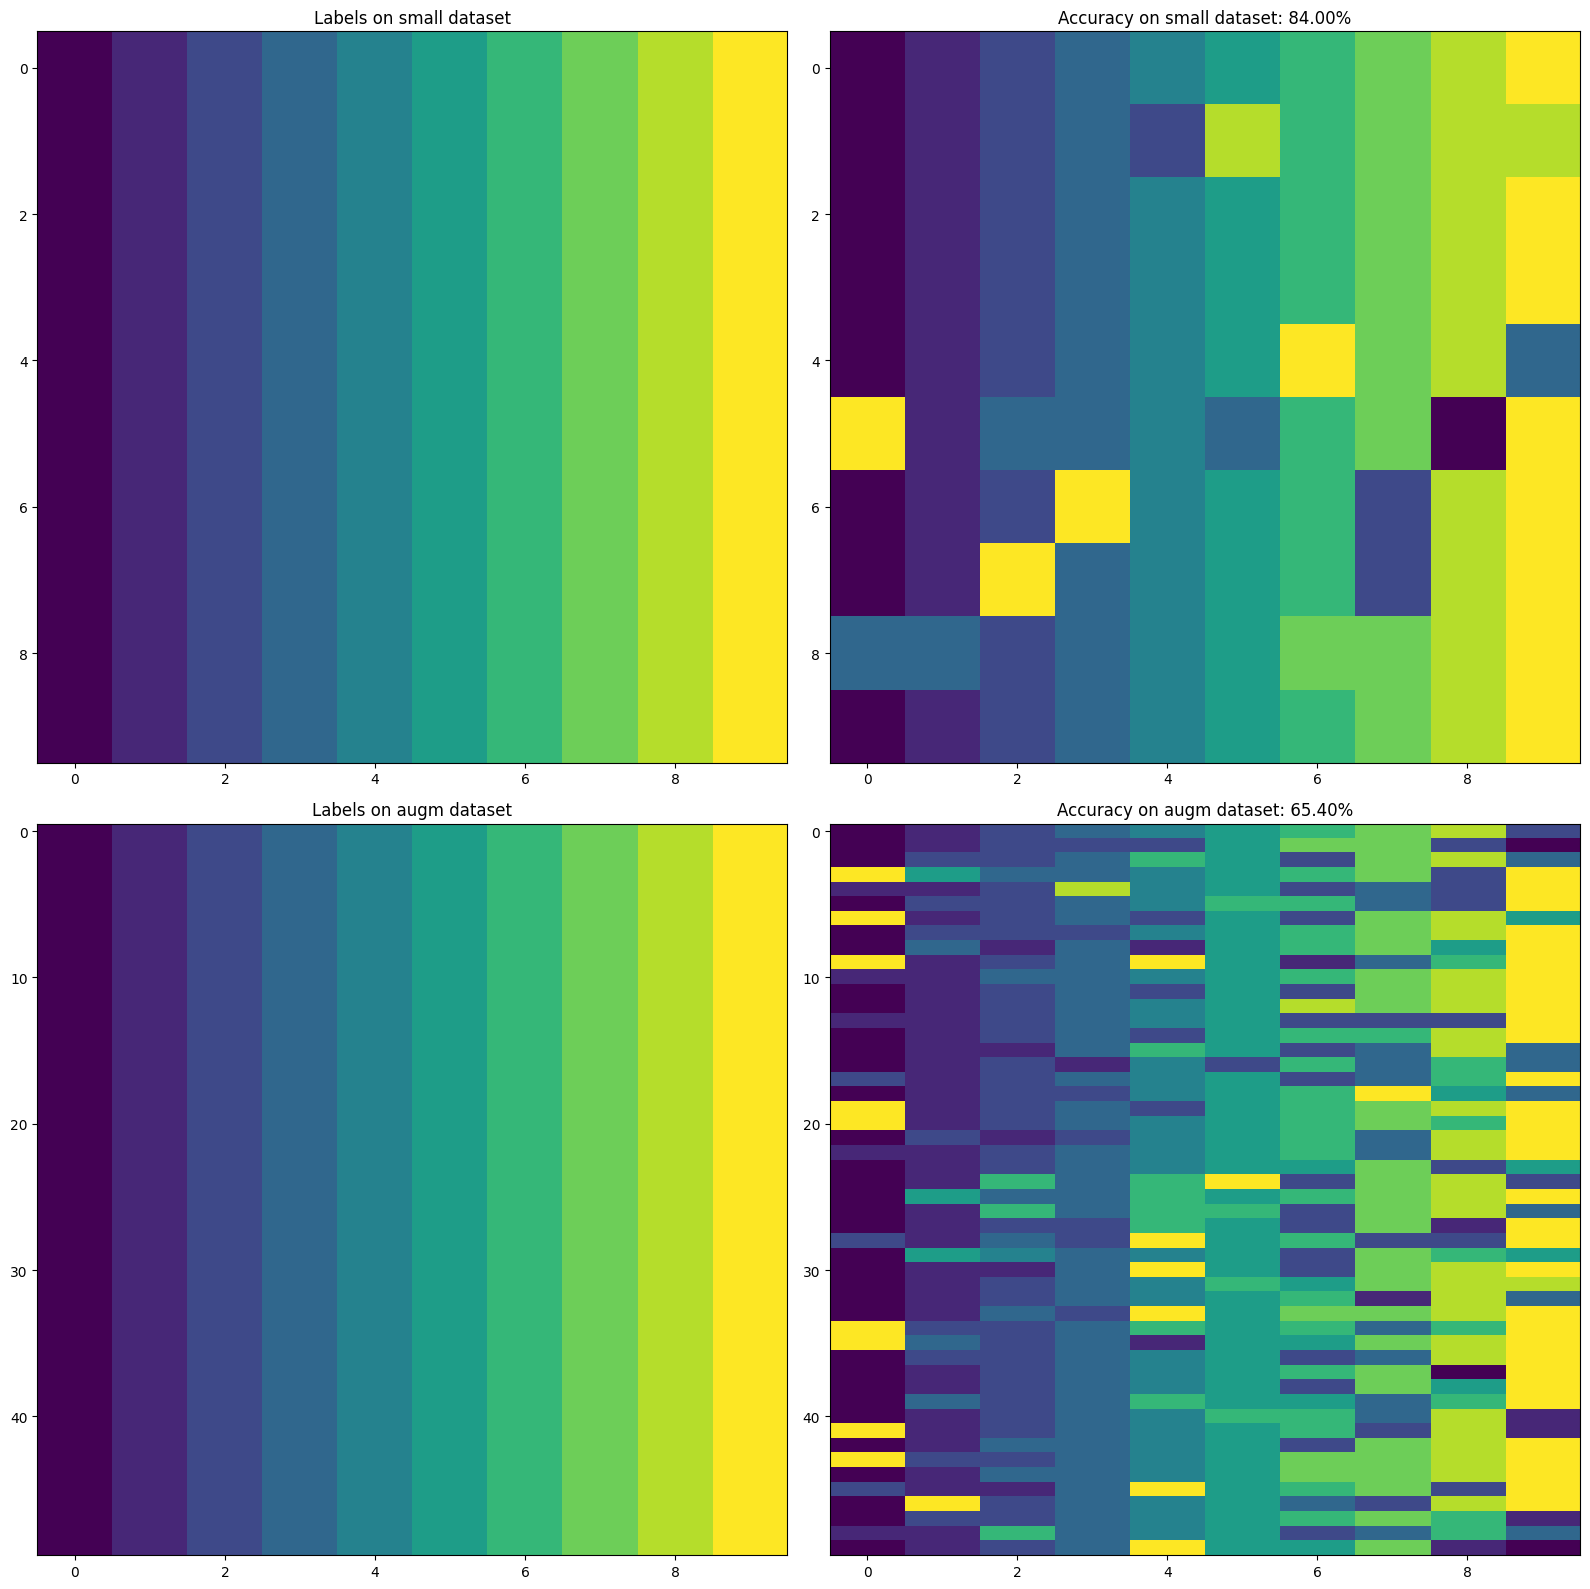

In [15]:
# Visualize predicted vs true labels
fig, axs = plt.subplots(2, 2, figsize=(16, 16))

axs[0, 0].imshow(labels.reshape((-1, 10)), aspect="auto")
axs[0, 1].imshow(predicted_labels.reshape((-1, 10)), aspect="auto")
axs[0, 0].set_title("Labels on small dataset")
axs[0, 1].set_title("Accuracy on small dataset: {:.2f}%".format(100 * accuracy))

axs[1, 0].imshow(labels_a.reshape((-1, 10)), aspect="auto")
axs[1, 1].imshow(predicted_labels_a.reshape((-1, 10)), aspect="auto")
axs[1, 0].set_title("Labels on augm dataset")
axs[1, 1].set_title("Accuracy on augm dataset: {:.2f}%".format(100 * accuracy_a))

plt.tight_layout()


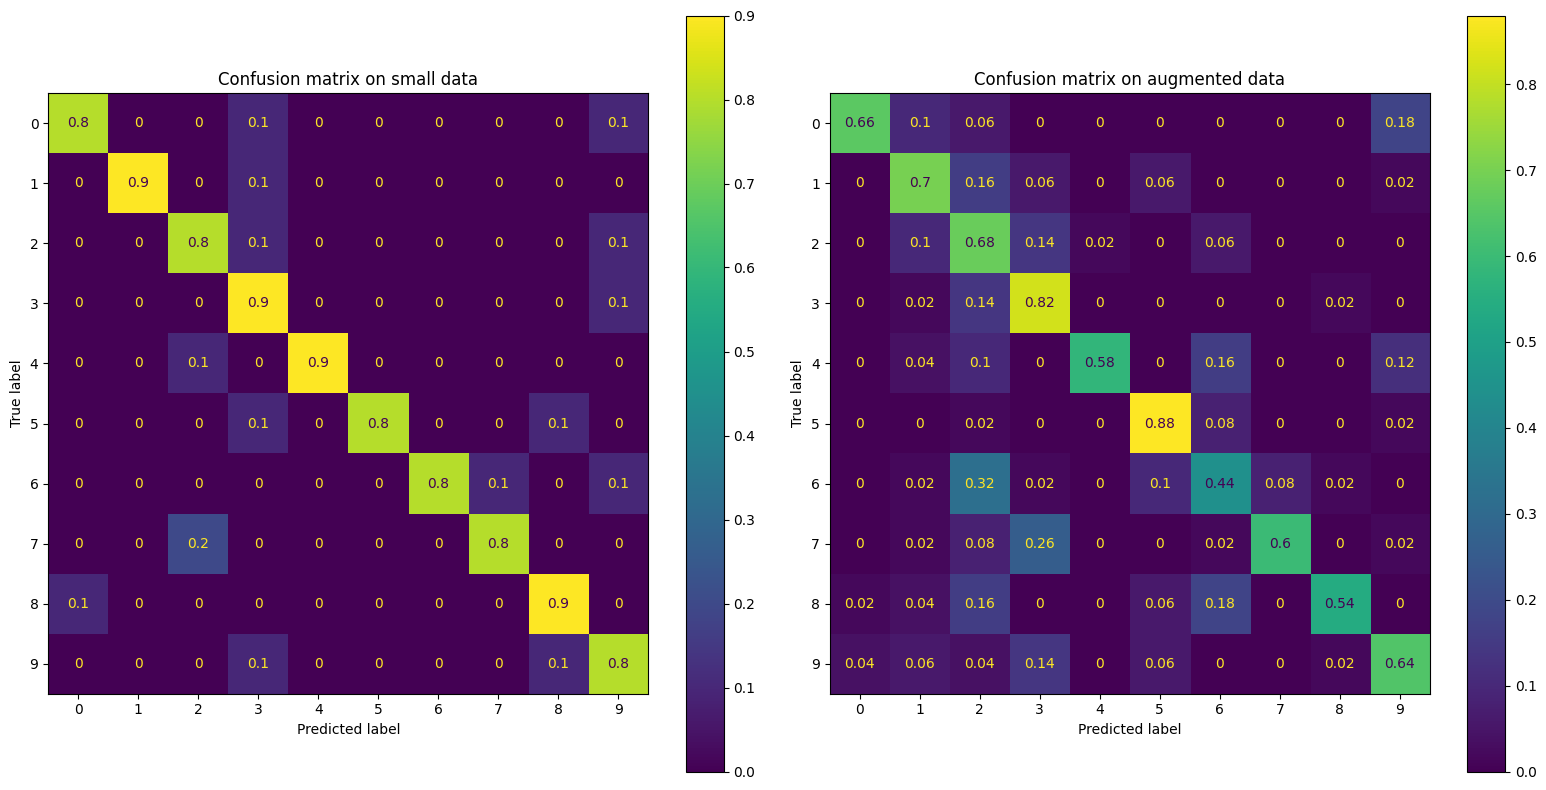

In [16]:
cm = confusion_matrix(labels, predicted_labels)
cm = cm / cm.sum(axis=-1)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))

cm_a = confusion_matrix(labels_a, predicted_labels_a)
cm_a = cm_a / cm_a.sum(axis=-1)
cm_display_a = ConfusionMatrixDisplay(
    confusion_matrix=cm_a, display_labels=np.arange(10)
)


fig, axs = plt.subplots(1, 2, figsize=(16, 8))
cm_display.plot(ax=axs[0])
axs[0].set_title("Confusion matrix on small data")

cm_display_a.plot(ax=axs[1])
axs[1].set_title("Confusion matrix on augmented data")

plt.tight_layout()


## 3. Online SSL

Now, instead of having all the data available at once, images will be received online: at each time $t$, a new image $x_t$ is observed and the algorithm has to output a label $y_t$. 

Use the function `create_user_profile` to capture a training set of labeled data (of your face and someone else). The faces will be preprocessed and saved in the folder `data/faces`. They will be loaded by `online_face_recognition`.


### Implementation

Choose the hyperparameters and complete the functions `online_ssl_update_centroids` and `online_ssl_compute_solution`. 

Modify your code to be able to disregard faces it cannot recognize.

* Tips:
    * You can use the functions `build_similarity_graph` and `build_laplacian`.

### Question 3.1 - Attach to this notebook some of the resulting frames of online face recognition. 

* Tips: 
    * You can save the resulting frame and add it to the notebook in a markdown cell as `![title](picture.png)`

We use the incremental k-centers and the graph quantization for online learning. The performances are already quite good, when dealing with a very few labelled images.

Below are a few results I obtained, using 2 labelled faces: Colin Firth and Samuel L. Jackson. The 2 faces are successfully detected in most simple cases.

|  | Perfectly detected face | Detected face, but would require <br>Non-Max Suppression | Not detected face |
|---|---|---|---|
| Example | ![Colin](results/Colin.png) | ![Samuel](results/Samuel.png) | ![Samuel_pb](results/Samuel_pb.png) |

We notice that there are some problems with this method:
* A moving face is less likely to be recognised, as the face detection by OpenCV will be less robust and the bounding box will move a lot.
* Some bounding boxes are present while they don't correspond to any face. This is due to OpenCV detection.
* The recognition highly depends on the background. Instead of a per-pixel comparison, we could use key points like Harris corners. 

> **Note:** to run the experiment with Colin Firth and Samuel Jackson known, one can run 
> ```
> online_face_recognition(
>     ["Samuel", "Colin"],
>     partial(IncrementalKCenters, update_face_dataset=False),
>     n_pictures=15,
>     video_filename="data/extra_small_video.mp4",
> )
> ```
    
### Question 3.2 - What strategy did you use to label a face as unknown? Attach to this notebook an example of a unknown face being correctly labeled as unknown.

* Tips
    * If you identify a face as unknown, you can return `[("unknown", score)]` from the function `online_ssl_compute_solution`.

In order to detect an unknown face, we threshold the predictions: we only keep the predictions where the probability of belonging is above 0.9.
We are then able to detect unknown faces. However, some faces are now not confident enough, like when the face is moving a lot:

|  | True unknown face | False unknown face |
|---|---|---|
| Example | ![unknown](results/unknown.png) | ![Samuel_unknown](results/Samuel_unknown.png) |

Once again, using more robust face descriptors could help delete false positive unknown detections.


In [17]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import os
import sys
from scipy.spatial import distance
import scipy.io as sio

from helper_online_ssl import create_user_profile, online_face_recognition


In [18]:
"""
Define parameters for face recognition with HFS
"""
params_online_ssl = {}
params_online_ssl["laplacian_regularization"] = 1
params_online_ssl["var"] = 10
params_online_ssl["eps"] = 0
params_online_ssl["k"] = 10
params_online_ssl["laplacian_normalization"] = "rw"
params_online_ssl["c_l"] = 0.95
params_online_ssl["c_u"] = 0.01


In [19]:
class IncrementalKCenters:
    def __init__(
        self,
        labeled_faces,
        labels,
        label_names,
        max_num_centroids=50,
        update_face_dataset=False,
    ):
        #  Number of labels
        self.n_labels = max(labels)

        #  Dimension of the input image
        self.image_dimension = labeled_faces.shape[1]

        #  Check input validity
        assert set(labels) == set(
            range(1, 1 + self.n_labels)
        ), "Initially provided faces should be labeled in [1, max]"
        assert len(labeled_faces) == len(
            labels
        ), "Initial faces and initial labels are not of same size"

        #  Number of labelled faces
        self.n_labeled_faces = len(labeled_faces)

        # Model parameter : number of maximum stored centroids
        self.max_num_centroids = max_num_centroids

        # Model centroids (inital labeled faces). Shape = (number_of_centroids, dimension)
        self.centroids = labeled_faces

        # Centroids labels
        self.Y = labels

        # Label names (= user names)
        self.label_names = label_names

        # Variables that are initialized in online_ssl_update_centroids()
        self.centroids_distances = None
        self.taboo = None
        self.V = None
        self.init = True

        # index of x_t (initialized later)
        self.last_face = None

        # update dataset if recurrent new face is encountered
        self.update_face_dataset = update_face_dataset

    def initialize(self):
        """
        Initialization after the first time that the maximum number of centroids is reached.
        """
        #  Compute the centroids distances
        self.centroids_distances = distance.cdist(self.centroids, self.centroids)

        #  set labeled nodes and self loops as infinitely distant, to avoid merging labeled centroids
        np.fill_diagonal(self.centroids_distances, +np.Inf)
        self.centroids_distances[
            0 : self.n_labeled_faces, 0 : self.n_labeled_faces
        ] = +np.Inf

        # put labeled nodes in the taboo list
        self.taboo = np.array(range(self.centroids.shape[0])) < self.n_labeled_faces

        # initialize multiplicity
        self.V = np.ones(self.centroids.shape[0])

    def online_ssl_update_centroids(self, face):
        """
        TO BE COMPLETED

        Update centroids, multiplicity vector V, labels Y.

        Note: In Y, set label to 0 for unlabeled faces.

        Parameters
        ----------
        face : array
            New sample

        Returns
        --------
        List with the scores for each possible label:
            [(label_1, score_1), (label_2, score_2), ...]
        """

        assert self.image_dimension == len(face), "new image not of good size"

        # Case 1: maximum number of centroids has been reached.
        if self.centroids.shape[0] >= self.max_num_centroids + 1:
            if self.init:
                #  Initialization after the first time that the maximum number of centroids is reached
                self.initialize()
                self.init = False
            """
            Find c_rep and c_add following Algorithm 1.
            
            - c_1, c_2 = two closest centroids (minimum distance) such that at least one of them is not in self.taboo.
            - c_rep = centroid in {c_1, c_2} that is in self.taboo. If none of them is in self.taboo, c_rep is the one
                      with largest multiplicity.
            - c_add = centroid in {c_1, c_2} that is not c_rep.
            """
            # c_rep, c_add = None, None
            distance_taboo = self.centroids_distances.copy()
            distance_taboo[~self.taboo, :] = np.inf
            # distance_taboo is the centroids_distances where rows in taboo are set to + infty
            c_1 = distance_taboo.min(axis=1).argmin()  # c_1 can't be in taboo
            c_2 = distance_taboo[c_1, :].argmin()

            if self.taboo[c_2]:  # c_1 not in taboo and c_2 in taboo
                c_rep = c_2
                c_add = c_1
            elif (
                self.V[c_1] > self.V[c_2]
            ):  # c_1 not in taboo and c_2 not in taboo and c_1 has largest multiplicity
                c_rep = c_1
                c_add = c_2
            else:
                c_rep = c_2
                c_add = c_1

            """
            Update data structures: self.centroids and self.V
            """
            # traditional update: doesn't add any new face to the dataset
            if not self.update_face_dataset:
                self.V[c_rep] += self.V[c_add]
                self.centroids[c_add, :] = face
                self.V[c_add] = 1

            # if a reccurent face is seen, add it to the dataset
            else:
                # if the representative face has been seen 10 times, but is not labelled, we label it
                if not self.taboo[c_rep] and self.V[c_rep] > 4:
                    self.taboo[c_rep] = True
                    self.taboo[c_add] = True
                    new_label = np.max(self.Y) + 1
                    self.Y[c_rep] = new_label
                    self.Y[c_add] = new_label
                    self.label_names += [f"Person {new_label}"]
                    self.n_labeled_faces += 1
                    self.n_labels += 1

                # if the representative face has been labelled, but it has been seen less than 10 times,
                # we add clasest face to the labelled dataset
                if self.taboo[c_rep] and (self.Y == self.Y[c_rep]).sum() < 4:
                    # add new label to the dataset
                    self.Y = np.append(self.Y, self.Y[c_rep])
                    self.taboo = np.append(self.taboo, True)
                    self.centroids = np.concatenate(
                        [self.centroids, np.array([self.centroids[c_add]])], axis=0
                    )
                    self.V = np.append(self.V, self.V[c_add])

                    # update distance matrix (in both directions !)
                    distance_with_new_centroid = distance.cdist(
                        np.array([self.centroids[-1]]),
                        self.centroids,
                    )[0]
                    self.centroids_distances = np.concatenate(
                        [
                            self.centroids_distances,
                            np.array([distance_with_new_centroid[:-1]]),
                        ],
                        axis=0,
                    )
                    self.centroids_distances = np.concatenate(
                        [
                            self.centroids_distances,
                            np.array([distance_with_new_centroid]).T,
                        ],
                        axis=1,
                    )

                    # update internal counters
                    self.n_labeled_faces += 1
                    self.max_num_centroids += 1

                # Otherwise, we do a standard update
                else:
                    self.V[c_rep] += self.V[c_add]

                self.centroids[c_add, :] = face
                self.V[c_add] = 1

            """
            Update the matrix containing the distances.
            """
            dist_row = distance.cdist(
                np.array([self.centroids[c_add]]), self.centroids
            )[0]
            dist_row[c_add] = +np.inf
            self.centroids_distances[c_add, :] = dist_row
            self.centroids_distances[:, c_add] = dist_row
            self.last_face = c_add

        # Case 2: create new centroid with face
        # Remark: the multiplicities vector self.V is initialized in self.initialize()
        else:
            current_len = len(self.centroids)
            self.Y = np.append(self.Y, 0)
            self.centroids = np.vstack([self.centroids, face])

    def online_ssl_compute_solution(self):
        """
        TO BE COMPLETED.

        Returns a prediction corresponding to self.last_face.
        """

        # Multiplicity matrix
        if self.init:
            V = np.diag(np.ones(self.centroids.shape[0]))
            self.last_face = self.centroids.shape[0] - 1
        else:
            V = np.diag(self.V)

        # Build quantized graph and its regularized Laplacian

        Wq = build_similarity_graph(
            self.centroids,
            params_face_rec["var"],
            params_face_rec["eps"],
            params_face_rec["k"],
        )
        L = build_laplacian(V @ Wq @ V, params_face_rec["laplacian_normalization"])
        Q = L + params_face_rec["laplacian_regularization"] * np.eye(Wq.shape[0])

        # Compute the hard HFS solution f.
        labels, f = compute_hfs(Q, self.Y, soft=True, **params_online_ssl)

        # Return the score for each possible label
        num_classes = len(np.unique(self.Y)) - 1
        label_scores = []
        for ii in range(num_classes):
            label = self.label_names[ii]
            score = f[self.last_face, ii]
            label_scores.append((label, score))

        # handle unknown faces
        label_scores = [
            label_score for label_score in label_scores if label_score[1] > 0.9
        ]
        if len(label_scores) == 0:
            label_scores = [("Unknown", 1)]
        return label_scores


In [20]:
# create_user_profile("bob2", video_filename="data/Valentine kill Harry scene _ Kingsman.mp4")  # choose your names here :)
# create_user_profile('alice')
# online_face_recognition(['bob', 'alice'], IncrementalKCenters, n_pictures=15)


### Question 4.1 - You can now classify faces as either known (i.e. belong to a class) or unknown (i.e. belong to no class). How would you modify the algorithm to automatically learn to classify new classes? That is, how can you modify the algorithm so that faces that appear unfrequently are labeled as unknown, but once a specific face has been seen enough times it gets assigned an automatic label (e.g. AutoBob) and from that point it is treated as a new class. 

* Tips: 
    * Think back to the idea of incremental clustering as unsupervised classification

In unsupervised classification, a large eigenvalues compared to other would imply a new cluster. Here, a large multiplicity on a specific centroid implies a new cluster / face. The ideas of the proposed algorithm are:
1. if there is an unlabelled recurrent face, we label it as `New Person`.
2. if there is a labelled recurrent face and it has too few samples, we make sure to keep the closest sample in the dataset
3. otherwise, we proceed to the standard update.

We can define a new workflow as shown below ![Figure 2](results/proposed_workflow.png)

We run the same experiment as before, but now, Colin Firth is an unknown face.

|  | Correctly Labelled Recurrent Face | Incorrectly Labelled Recurrent Face </br> (Samuel L. Jackson is supposed to be known) |
|---|---|---|
| Example | ![person2](results/person2.png)<br>![person4](results/person4.png) | ![person3](results/person3.png)) |

Despite nice performances of that method, we can detect a few drawbacks:
* as mentioned before, the method isn't robust enough. It can easily add a face to the dataset, while this face is already considered as known. 
* the size of the dataset keeps increasing. As more faces appear, the dataset will save these new faces, without any limit.

> **Note:** to run the experiment with only Samuel Jackson known and update the dataset, one can run 
> ```
> online_face_recognition(
>     ["Samuel"],
>     partial(IncrementalKCenters, update_face_dataset=True),
>     n_pictures=15,
>     video_filename="data/extra_small_video.mp4",
> )
> ```
    
### Question 4.2 - In class we considered different kinds of metric for (semi) supervised learning. Looking at the face classification task, try to quantify how the offline-online, exact-quantized, and inductive-transductive axes influence each other. In particular given $l$ labeled faces, $u = N - l$ unlabeled faces, and $m$ extra/test faces design an experimental study to quantify these trade-offs, both in terms of transductive and inductive error, as well as online/batch error. Examples of combinations that can be used to study these axes are:
* Supervised vs Semi-supervised
    * A comparison between a supervised learner (of your choice) trained on the $l$ labeled faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces
    * A comparison between a supervised learner (of your choice) trained on the $N$ labeled and unlabeled (you reveal everything here) faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces.
* Inductive vs Transductive
    * A comparison between a supervised learner (of your choice) trained on the $l$ labeled faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces evaluated on the $N$ revealed points and then on the $m$ unrevealed points.
* Supervised vs Semi-supervised and Inductive vs Transductive
    * A comparison between a supervised learner (of your choice) trained on the $N$ labeled and unlabeled (you reveal everything here) faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces, evaluated on the $N$ revealed points and then on the $m$ unrevealed points.
* Online vs Batch
    * A comparison between a supervised learner (of your choice) trained on the $N$ labeled faces and an online supervised learner (of your choice) trained revealing the $N$ labels one at a time
* Exact vs Quantized
    * A comparison between a semi-supervised learner (of your choice) trained on the $N$ labeled and unlabeled (you reveal everything here) faces using a certain memory budget, and the same learner with a constrained memory budget.
* Exact vs Quantized and Online vs Batch and Inductive vs Transductive
    * A comparison between a semi-supervised online learner (of your choice) trained with and without quantization, evaluated both on the $N$ faces revealed during training, and $m$ faces unrevealed. You can further compare the online performance of the learner against the performance of an "hindsight" learner that saw the labels all at once

**Supervised vs Semi-Supervised**

On the first experiment, we draw the different of performances between a supervised and a semisupervised classifier on the whole data.
* Semi-supervised classifier: soft HFS on 20 components per face chosen by a PCA
* Supervised classifier: KMeans on 20 components per face chosen by a PCA
* we choose a number $u$ of missing data in the dataset:
    * the SSL classifier is trained on the $l+u$ data. The best hyper parameters are from our previous study.
    * the SL classifier is trained on the $l$ data. The best hyper parameters are found thanks to a grid search.
* both classifier are evaluated on the whole known $N$ data.
* We display the accuracy on $N$ samples with respect to the number of missing samples $u$.

> **Note:** We apply a PCA before both classifier to have more robust results. While this a necessary for the SL classifier in order to obtain satisfying results, it is more superfluous for the SSL classifier as it doesn't improve the performances.

We update `load_image_data` function to choose a number of missing data. We update the `compute_hfs` function to choose the number of classes in the dataset, as a high number of missing data might hide classes (see question 1.2)

In [21]:
FRAME_SIZE = 96
NB_IMGS_AUGMENTED = 50


def load_image_data(preprocess_fn):
    cc = cv2.CascadeClassifier(
        os.path.join("data", "haarcascade_frontalface_default.xml")
    )
    # Loading images
    images = np.zeros((100, FRAME_SIZE**2))
    labels = np.zeros(100, dtype=np.uint32)

    for i in np.arange(10):
        for j in np.arange(10):
            im = imread("data/10faces/%d/%02d.jpg" % (i, j + 1))
            box = cc.detectMultiScale(im)
            top_face = {"area": 0}

            for cfx, cfy, clx, cly in box:
                face_area = clx * cly
                if face_area > top_face["area"]:
                    top_face["area"] = face_area
                    top_face["box"] = [cfx, cfy, clx, cly]

            fx, fy, lx, ly = top_face["box"]
            gray_im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
            gray_face = gray_im[fy : fy + ly, fx : fx + lx]

            """
            Apply preprocessing to balance the image (color/lightning), such as filtering 
            (cv.boxFilter, cv.GaussianBlur, cv.bilinearFilter) and
            equalization (cv.equalizeHist).   
            """
            gray_face = preprocess_fn(gray_face)

            # resize the face and reshape it to a row vector, record labels
            images[j * 10 + i] = gray_face.reshape((-1))
            labels[j * 10 + i] = i + 1

    """
    select 4 random labels per person and reveal them  
    masked_labels: (n x 1) masked label vector, where entries Y_i take a values in [1, ..., num_classes] if the node is  
              labeled, or 0 if the node is unlabeled (masked)   
    """
    return images, labels


images, labels = load_image_data(preprocess_image)


/tmp/ipykernel_1213/75652925.py:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imread("data/10faces/%d/%02d.jpg" % (i, j + 1))
/tmp/ipykernel_1213/431548746.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im = cv2.resize(image, (output_frame_size, output_frame_size)).astype(np.float)


In [22]:
def compute_hfs(L, Y, num_classes, soft=False, **params):
    """
    TO BE COMPLETED

    Function to perform HFS (hard or soft!).

    Parameters
    ----------
    L : array
        Graph Laplacian, (n x n) matrix (regularized or not)
    Y : array
        (n, ) array with nodes labels [0, 1, ... , num_classes] (0 is unlabeled)
    soft : bool
        If True, compute soft HFS. Otherwise, compute hard HFS.

    Returns
    --------
        Labels, class assignments for each of the n nodes
    """

    num_samples = L.shape[0]

    """
    Build the vectors:
    y = (n x num_classes) target vector 
    l_idx = shape (l,) vector with indices of labeled nodes
    u_idx = shape (u,) vector with indices of unlabeled nodes
    """
    y = np.zeros((num_samples, num_classes))
    l_idx = np.arange(len(Y))[Y != 0]
    u_idx = np.arange(len(Y))[Y == 0]
    y[l_idx, Y[l_idx].astype(int) - 1] = 1

    if not soft:
        """
        Compute hard HFS.

        f_l = solution for labeled data.
        f_u = solution for unlabeled data
        f   = solution for all data
        """
        f_l = y[l_idx]
        L_ul = L[u_idx, :][:, l_idx]
        L_uu = L[u_idx, :][:, u_idx]
        f_u = np.linalg.solve(L_uu, -L_ul @ f_l)

        f = np.zeros(y.shape)
        f[l_idx] = f_l
        f[u_idx] = f_u

    else:
        """
        Compute soft HFS.
        f = harmonic function solution
        C = (n x n) diagonal matrix with c_l for labeled samples and c_u otherwise
        """
        C = np.zeros(num_samples)
        C[l_idx] = params["c_l"]
        C[u_idx] = params["c_u"]
        C = np.diag(C)
        f = np.linalg.solve(np.linalg.pinv(C) @ L + np.eye(num_samples), y)

    """
    return the labels assignment from the hfs solution, and the solution f
    labels: (n x 1) class assignments [1,2,...,num_classes]    
    f : harmonic function solution
    """
    labels = np.argmax(f, axis=1) + 1
    return labels, f


In [27]:
images_train, labels_train = images.copy(), labels.copy()
n = int(np.sqrt(len(images_train[0])))

accuracies = []
for nb_unmasked in np.arange(90, 0, -2):
    for i in range(20):
        masked_labels = mask_labels(labels_train, nb_unmasked, per_class=False)
        masked_labels[:10] = np.arange(1, 11)

        labelled_train_images = images_train[masked_labels != 0]

        # SSL Training
        n_components = min(20, len(labelled_train_images))
        pca = PCA(n_components=n_components).fit(images_train)
        train_images_pca = pca.transform(images_train)
        L = build_laplacian_regularized(
            train_images_pca,
            params_face_rec["laplacian_regularization"],
            params_face_rec["var"],
            params_face_rec["eps"],
            params_face_rec["k"],
            params_face_rec["laplacian_normalization"],
        )

        # SSL Evaluation
        predicted_labels_ssl, f = compute_hfs(
            L, masked_labels, num_classes=10, soft=True, **params_face_rec
        )
        accuracy_ssl = np.equal(predicted_labels_ssl, labels_train).mean()

        # SL training
        pca = PCA(n_components=n_components).fit(labelled_train_images)
        labelled_train_images_pca = pca.transform(labelled_train_images)
        clf = SVC(C=44151, class_weight="balanced", gamma=0.0005)
        clf.fit(labelled_train_images_pca, labels_train[masked_labels != 0])

        # SL evaluation
        train_images_pca = pca.transform(images_train)
        predicted_labels_sl = clf.predict(train_images_pca)
        accuracy_sl = np.equal(predicted_labels_sl, labels_train).mean()

        accuracies.append(
            {
                "ratio_missing": np.mean(masked_labels == 0),
                "accuracy_sl": accuracy_sl,
                "accuracy_ssl": accuracy_ssl,
            }
        )

accuracies = pd.DataFrame.from_records(accuracies)


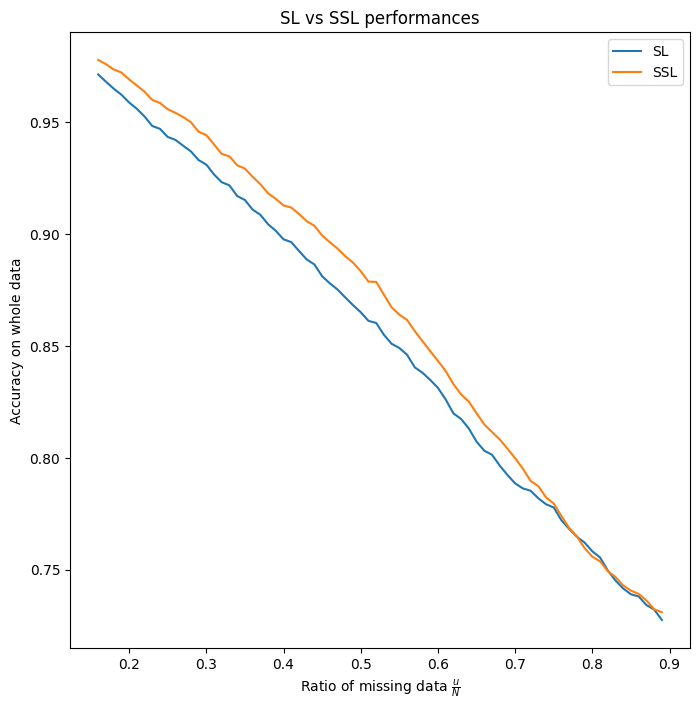

In [29]:
averaged_accuracies = accuracies.groupby(["ratio_missing"]).mean().rolling(10).mean()

fig, axs = plt.subplots(1, 1, figsize=(8, 8))
axs.plot(averaged_accuracies.index, averaged_accuracies["accuracy_ssl"], label="SL")
axs.plot(averaged_accuracies.index, averaged_accuracies["accuracy_sl"], label="SSL")
axs.set_title("SL vs SSL performances")
axs.set_ylabel("Accuracy on whole data")
axs.set_xlabel(r"Ratio of missing data $\frac{u}{N}$")
axs.legend()


Thanks to the plot above, we understand that:
* our SSL model is performing consistently better than our SL model. 
* both model have decreasing performances with respect to the number of missing data.
* The gap between the SSL and SL classifiers is firstly increasing with respect to the number of missing data. This means that our SSL classifier benefits unlabelled data, when the ratio of missing data is between 0 and 60%. After 60%, the gap decreases, meaning that there are too much unlabelled data for the SSL classifier to be able to infer interesting patterns.

**Transductive vs Inductive**

In the second experiment, we want to test the transductive setting on both models:
* 20% of the data is kept in a test set. This data is called $m$.
* the SL classifier is trained on the $l$ labelled data only. It is tested on the $m$ samples.
* It is a bit harder to define a transductive setting in the HFS. To do so, we train our SSL classifier on the $l+u$ data. Once data, we label the $u$ labels from the trained model. Then, we run our classifier on the $m$ samples, which are considered unlabelled.
* We display the accuracy on $m$ samples with respect to the number of missing samples $u$.

In [ ]:
idx_train = np.arange(80)
idx_test = np.arange(80, 100)
images_train, labels_train = images.copy()[idx_train], labels.copy()[idx_train]
images_test, labels_test = images.copy()[idx_test], labels.copy()[idx_test]
n = int(np.sqrt(len(images_train[0])))

accuracies = []
for nb_unmasked in np.arange(90, 0, -2):
    for i in range(20):
        masked_labels = mask_labels(labels_train, nb_unmasked, per_class=False)
        masked_labels[:10] = np.arange(1, 11)

        labelled_train_images = images_train[masked_labels != 0]

        # SSL Training
        n_components = min(20, len(labelled_train_images))
        pca = PCA(n_components=n_components).fit(images_train)
        train_images_pca = pca.transform(images_train)
        L = build_laplacian_regularized(
            train_images_pca,
            params_face_rec["laplacian_regularization"],
            params_face_rec["var"],
            params_face_rec["eps"],
            params_face_rec["k"],
            params_face_rec["laplacian_normalization"],
        )
        new_labels, f = compute_hfs(
            L, masked_labels, num_classes=10, soft=True, **params_face_rec
        )
        new_labels = np.append(new_labels, np.zeros(20))
        # SSL Evaluation
        images_pca = pca.transform(images)
        L = build_laplacian_regularized(
            images_pca,
            params_face_rec["laplacian_regularization"],
            params_face_rec["var"],
            params_face_rec["eps"],
            params_face_rec["k"],
            params_face_rec["laplacian_normalization"],
        )
        predicted_labels_ssl, f = compute_hfs(
            L, new_labels, num_classes=10, soft=True, **params_face_rec
        )
        accuracy_ssl = np.equal(predicted_labels_ssl[idx_test], labels_test).mean()

        # SL training
        pca = PCA(n_components=n_components).fit(labelled_train_images)
        labelled_train_images_pca = pca.transform(labelled_train_images)
        clf = SVC(C=44151, class_weight="balanced", gamma=0.0005)
        clf.fit(labelled_train_images_pca, labels_train[masked_labels != 0])

        # SL evaluation
        test_images_pca = pca.transform(images_test)
        predicted_labels_sl = clf.predict(test_images_pca)
        accuracy_sl = np.equal(predicted_labels_sl, labels_test).mean()

        accuracies.append(
            {
                "ratio_missing": np.mean(masked_labels == 0),
                "accuracy_sl": accuracy_sl,
                "accuracy_ssl": accuracy_ssl,
            }
        )

accuracies = pd.DataFrame.from_records(accuracies)


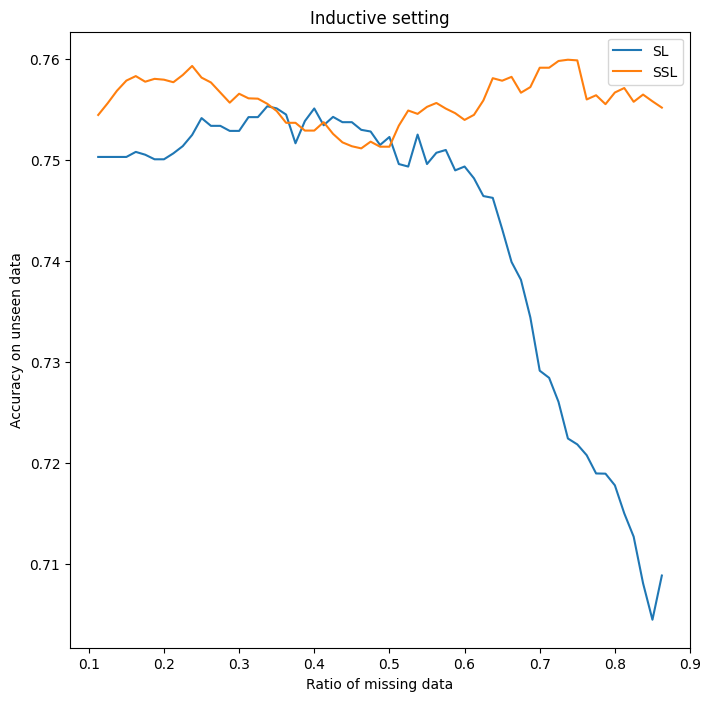

In [ ]:
averaged_accuracies = accuracies.groupby(["ratio_missing"]).mean().rolling(10).mean()

fig, axs = plt.subplots(1, 1, figsize=(8, 8))
axs.plot(averaged_accuracies.index, averaged_accuracies["accuracy_ssl"], label="SL")
axs.plot(averaged_accuracies.index, averaged_accuracies["accuracy_sl"], label="SSL")
axs.set_title("Inductive setting")
axs.set_ylabel("Accuracy on unseen data")
axs.set_xlabel("Ratio of missing data")
axs.legend()


Thanks to the plot above, we understand that:
* both models act roughly the same on transductive data, when there is a low amount of unlabelled data.
* the differences of accuracy at low ratio of missing data is explained by the difference of performances between the classifier: the SSL classifier is slightly better than the SL classifier
* when there is a huge number of missing data (> 60%), the SSL performs better. As it firstly labels the unlabelled data, before testing on unseen data, the SSL classifier can access more data. 